In [7]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
from collections import Counter

In [2]:
def distance(a, b):
    # Calculates the distance between points a and b
    return ((a[0]-b[0])**2 + (a[1]-b[1])**2)**0.5

# Test
assert(distance([0,0],[3,4])==5)

In [3]:
# Taken from a class notebook. makes the animation.
def make_animation(sim, total_frames, steps_per_frame=1, interval=100):
    from matplotlib.animation import FuncAnimation
    from IPython.display import HTML
    from tqdm import tqdm
    
    def update(frame_number):
        for _ in range(steps_per_frame):
            sim.step()
        progress_bar.update(1)
        return sim.draw()

    sim.initialize()
    progress_bar = tqdm(total=total_frames)
    animation = FuncAnimation(
        sim.figure, update, init_func=lambda: [], frames=total_frames, interval=interval)
    output = HTML(animation.to_html5_video())
    sim.figure.clf()
    return output

In [82]:
class ClinicsSim:
    """
    This class holds all the functions that create the simulation of health clinics usage over time.
    """
    def __init__(self, houses_pos, clinics_pos , clinic_capacity = 10, max_distance = 5, 
                 p_d = 0.1, p_r = 0.1, alpha = 1, beta = 2, gamma = 1/2, 
                 rare_disease_rate = .2, graph = True, closest = True):
        """
        Inputs:

            houses_pos (list)  The coordinates of the houses.

            clinics_pos (list) The coordinates of the clinics.

            clinic_capacity (int) The maximum number of people a clinic can serve at once
            
            max_distance (float) The maximum distance a sick person will travel to visit a clinit
            
            p_d (float) The baseline probability of getting sick (if there are no clinics nearby)
            
            p_r (float) The baseline pobability of recovery (without treatment)
            
            alpha (float) Determines how far the clinics' prevention abilities reach.
            
            beta (float) Determines how much more a patient prefers to go to their reference clinic, compared 
            to their baseline preference (which is based on distance).
            
            gamma (float) Determines how good the doctors are at increasing the chances of recovery.
            
            rare_disease_rate (float) The rate of diseases that must be treated at the reference clinic
            
            closest (bool) Determines whether to use a minimize distance strategy to assign clinics. 
            If False, the function MCMC_assign_clinics is used.
        """ 
        self.houses_pos = houses_pos
        self.clinics_pos = clinics_pos
        self.capacity = clinic_capacity
        self.max_distance = max_distance
        if graph:
            self.figure, self.axes = plt.subplots(1, 2, figsize = (14,7))
        self.p_d = p_d
        self.p_r = p_r
        self.alpha = alpha 
        self.beta = beta
        self.gamma = gamma
        self.rare_disease_rate = rare_disease_rate
        
        # Statistics
        self.disease_prevalence = []
        self.sum_dist = 0
        
        # References
        self.closest = closest
        
    
    def initialize(self):
        """
        Creates the nodes and edges
        """ 
        self.graph = nx.MultiGraph()
        # Add houses in the graph
        for i in range(len(self.houses_pos)):
            self.graph.add_node(i, 
                                pos = self.houses_pos[i], 
                                p_s = self.p_d,
                                sick = 0, 
                                treating_at = None,
                                kind = "House")
        # Add clinics in the graph
        for i in range(len(self.clinics_pos)):
            self.graph.add_node(f"C{i}", pos = self.clinics_pos[i], capacity = self.capacity, kind = "Clinic")
            
        self.house_nodes = [i for i,j in self.graph.nodes(data=True) if j['kind']=="House"]
        self.clinic_nodes = [i for i,j in self.graph.nodes(data=True) if j['kind']=="Clinic"]
        
        # Add edges - the weight of the edge is inversely proportional to the square of the distance
        for house in self.house_nodes: 
            for clinic in self.clinic_nodes:
                dist = distance(self.graph.nodes[house]['pos'], self.graph.nodes[clinic]['pos'])
                # There is no edge after a certain maximum distance
                if dist < self.max_distance:
                    self.graph.add_edge(house, clinic, weight = 1/dist**2, edge_type = "Usage")
                    
        if self.closest:
            self.assign_clinics()
        
            for house in self.house_nodes:
                # Calculate the probability of being sick
                self.sick_func(house)
        self.normalize_weights()

                    

        
    def assign_clinics(self):
        """
        Determines the reference clinic for each node. It implements the minimum distance strategy
        """ 
        for house in self.house_nodes: 
            closest_clinic = None
            min_dist = float('inf')
            for clinic in self.clinic_nodes:
                dist = distance(self.graph.nodes[house]['pos'], self.graph.nodes[clinic]['pos'])
                if dist < min_dist:
                    closest_clinic = clinic
                    min_dist = dist
            self.sum_dist += min_dist
            self.graph.add_edge(house, closest_clinic, distance = min_dist, edge_type = "Reference")
            # Change the weights
            try:
                self.graph.edges[house, closest_clinic, 0]["weight"] *= self.beta
            except:
                pass
            # Add attribute
            self.graph.nodes[house]['reference'] = closest_clinic
        
    
    def normalize_weights(self):
        # Normalizes the edge weights
        
        for house in self.house_nodes:
            # Connections with nearby clinics
            node_edges = [(node, clinic, data) for node, clinic, data in self.graph.edges(house, data=True) if data["edge_type"]=="Usage"]
            # Nearby clinic names
            nearby_clinics = [clinic for house, clinic, data in node_edges]
            if len(nearby_clinics) != 0:
                clinic_weights = np.array([data['weight'] for house, clinic, data in node_edges])
                # Normalize it
                norm_weights = clinic_weights/clinic_weights.sum(0)
            index = 0
            for edge,clinic,data in node_edges:
                self.graph.edges[house,clinic,0]["norm_weight"] = norm_weights[index]
                index+= 1
        
    def step(self):
        """
        Implements one step of the simulation
        """
        self.normalize_weights()
        sicks = 0
        for house in self.house_nodes:
            
            
            # Healthy nodes might get sick
            if self.graph.nodes[house]["sick"] == 0:  
                if random.random() < self.graph.nodes[house]["p_d"]:
                    self.graph.nodes[house]["sick"] = 1
            
            # Sick nodes might recover
            else:
                sicks += 1
                # Choose a clinic to go to:
                if self.graph.nodes[house]['treating_at'] == None:
                    treat_clinic = self.decide_clinic(house)
                    previously_treated = False
                elif self.graph.nodes[house]['treating_at'] == "self":
                    treat_clinic = None
                    previously_treated = True
                else:
                    treat_clinic = self.graph.nodes[house]['treating_at']
                    previously_treated = True
                self.treatment(house, treat_clinic, previously_treated)
        self.disease_prevalence.append(sicks/len(self.houses_pos))
    
    def decide_clinic(self, node):
        # Connections with nearby clinics
        node_edges = [(node, clinic, data) for node, clinic, data in self.graph.edges(node, data=True) if data["edge_type"]=="Usage"]
        #print(node_edges)
        # Nearby clinic names
        nearby_clinics = [clinic for house, clinic, data in node_edges]
        
        if len(nearby_clinics) == 0:
            self.graph.nodes[node]["treating_at"] = "self"
            return None
        
        # There is a chance that the disease can only be treated at the reference clinic
        if random.random() < self.rare_disease_rate:
            chosen_clinic = self.graph.nodes[node]['reference']
            
            # If chosen clinic is too far, they don't go
            if len(self.graph.edges(node, chosen_clinic))==2:
                #print("hey")
                self.graph.nodes[node]["treating_at"] = "self"
                return None
            else:
                return chosen_clinic

        # If that's not the case, then pick a clinic based on the weights
        else:
            # Weights given to nearby clinics
            norm_weights = np.array([data['norm_weight'] for house, clinic, data in node_edges])

            # Choose a clinic proportional on the weight
            chosen_clinic = random.choices(
                population=nearby_clinics,
                weights=norm_weights,
                k=1
            )[0]
        
            return chosen_clinic
    
    
    def treatment(self, node, clinic, previously_treated):
        # If they are not being treated or the clinic is full
        if clinic == None or self.graph.nodes[clinic]["capacity"] == 0:
            if random.random() < self.p_r:
                self.graph.nodes[node]['sick'] = 0
        
        else: 
            # Assign house to this clinic
            self.graph.nodes[node]['treating_at'] = clinic
            if not previously_treated:
                # They use one doctor for treatment
                self.graph.nodes[clinic]["capacity"] -= 1
            recovery_prob = self.recovery_func(self.p_r)
            
            if self.graph.nodes[node]['reference'] == clinic:
                
                recovery_prob *= 1
            # If they recover, the doctor is free again
            if random.random() < recovery_prob:
                self.graph.nodes[node]['sick'] = 0
                self.graph.nodes[clinic]["capacity"] += 1
                self.graph.nodes[node]['treating_at'] = None
                
    def sick_func(self, house):
        # Calculates the probability of being sick based on the reference clinic's distance
        
        reference_clinic = [(node, clinic, key) for node, clinic, key, data in self.graph.edges(house, keys = True, data=True) if data['edge_type']=="Reference"][0][1]
        
        try:
            
            weight = 1/self.graph.edges[house, reference_clinic, 0]["distance"]
        except:

            weight = 1/self.graph.edges[house, reference_clinic, 1]["distance"]

        new_p_d = self.p_d - self.p_d * (self.alpha *weight**2/(1+self.alpha *weight**2))
        self.graph.nodes[house]['p_d'] = new_p_d
        
        
    def recovery_func(self, p_r):   
        # Calculates the recovery probability
        new_p_r = p_r + (1-p_r)*self.gamma
        return new_p_r
    
    def draw_nodes(self, color_by):
        fig, ax = plt.subplots(figsize = (8,8))
        color_map = {0: 'blue', 1: 'red'}
        pos = nx.get_node_attributes(self.graph,'pos')
        
        ax.clear()
        ax.axis('off')
        # Draw houses
        plot1 = nx.draw_networkx_nodes(self.graph, 
                               pos, 
                               ax=ax,
                               nodelist = self.house_nodes, 
                               node_size = 60,
                               node_color = [self.graph.nodes[i][color_by] for i in self.house_nodes],#[color_map[self.graph.nodes[i]['sick']] for i in self.house_nodes],
                               vmax = self.p_d,
                               vmin = 0
                              )
        if color_by == "p_d":
            from mpl_toolkits.axes_grid1 import make_axes_locatable
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("bottom", size="5%", pad=0.05)
            plt.colorbar(plot1, label="Infection Probability", cax= cax, orientation="horizontal")
        
        # Draw clinics
        plot2 = nx.draw_networkx_nodes(self.graph, 
                               pos, 
                               ax=ax,
                               nodelist = self.clinic_nodes, 
                               node_color = "Gray",#[self.graph.nodes[i]['capacity'] for i in self.clinic_nodes],
                               cmap = plt.cm.RdYlGn,
                               vmax = self.capacity,
                               vmin = 0)
                
            
    def draw(self):
        color_map = {0: 'green', 1: 'red'}
        pos = nx.get_node_attributes(self.graph,'pos')
        
        self.axes[0].clear()
        self.axes[0].axis('off')
        # Draw houses
        plot1 = nx.draw_networkx_nodes(self.graph, 
                               pos, 
                               ax=self.axes[0],
                               nodelist = self.house_nodes, 
                               node_size = 60,
                               node_color = [color_map[self.graph.nodes[i]['sick']] for i in self.house_nodes],
                               vmax = self.p_d,
                               vmin = 0
                              )
        from mpl_toolkits.axes_grid1 import make_axes_locatable
        divider = make_axes_locatable(self.axes[0])
        cax1 = divider.append_axes("bottom", size="5%", pad=0.05)
        plt.colorbar(plot1, label="Infection Probability", cax= cax1, orientation="horizontal")
        
        # Draw clinics
        plot2 = nx.draw_networkx_nodes(self.graph, 
                               pos, 
                               ax=self.axes[0],
                               nodelist = self.clinic_nodes, 
                               node_color = [self.graph.nodes[i]['capacity'] for i in self.clinic_nodes],
                               cmap = plt.cm.bone,
                               vmax = self.capacity,
                               vmin = 0)
        
        cax2 = divider.append_axes("left", size="5%", pad=0.05)
        plt.colorbar(plot2, label="Capacity", cax= cax2, orientation="vertical")
        cax2.yaxis.set_ticks_position('left')
        # Draw edges
        usage_edges = [(node1, node2) for node1, node2, data in self.graph.edges(data=True) if data['edge_type']=="Usage"]
        reference_edges = [(node1, node2) for node1, node2, data in self.graph.edges(data=True) if data['edge_type']=="Reference"]

        plot3 = nx.draw_networkx_edges(self.graph, 
                               pos, 
                               ax=self.axes[0],
                               edgelist = usage_edges,
                               width = 1,
                               edge_color=[self.graph.edges[i, j, 0]['norm_weight'] for i, j in usage_edges],
                               edge_cmap=plt.cm.binary,
                               edge_vmax = 1,
                               edge_vmin = -0.01
                              )
        
        plot4 = nx.draw_networkx_edges(self.graph, 
                               pos,
                               ax=self.axes[0],
                               edgelist = reference_edges,
                               edge_color = "green",
                               style = "dashed",
                               alpha = 0.5)
        
        
        self.axes[1].clear()
        plot5 = self.axes[1].plot(self.disease_prevalence, color = "black")
        
        self.axes[1].set_xlabel('step')
        self.axes[1].set_ylabel('proportion infected')
        self.axes[1].set_ylim(0, max(self.disease_prevalence) * 1.05 if len(self.disease_prevalence) > 0 else 1)
        self.axes[1].set_title('Step: ' + str(len(self.disease_prevalence)))
        #nx.draw_networkx_labels(self.graph, pos)
        return (plot1, plot2, plot3, plot4, plot5)
    
    def create_edges(self, ref_clinics):
        for house in self.house_nodes:
            #print(ref_clinics[house])
            clinic = ref_clinics[house]
            self.graph.nodes[house]['reference'] = clinic
            self.graph.add_edge(house, ref_clinics[house], distance = distance(self.graph.nodes[clinic]['pos'], self.graph.nodes[house]['pos']), edge_type = "Reference")
        for house in self.house_nodes:
            # Calculate the probability of being sick
            self.sick_func(house)

    def MCMC_assign_clinics(self, iterations=100, n_closest = 3, min_std = False):
        # Implements the minimum standard deviation and the mixed strategies
        self.n_houses = len(self.house_nodes)
        self.patient_count = {}
        self.changes = 0
        self.std = []
        self.sum_dist_lst = []
        # Assign to random clinics
        closest_clinics = {}
        ref_clinics = {}
        self.sum_dist = 0
        for house in self.house_nodes:
            distances_lst = []
            for clinic in self.clinic_nodes:
                distances_lst.append(distance(self.graph.nodes[house]['pos'],
                            self.graph.nodes[clinic]['pos']))
            # Gets the closest clinics
            closest_clinics[house] = [x for _,x in sorted(zip(distances_lst, self.clinic_nodes))][:n_closest-1]
            # Assigns the house to the closest one
            clinic = closest_clinics[house][0]
            ref_clinics[house] = clinic
            # Add to count
            if clinic in self.patient_count:
                self.patient_count[clinic] += 1
            else:
                self.patient_count[clinic] = 0

            dist = distance(self.graph.nodes[house]['pos'],
                            self.graph.nodes[clinic]['pos'])

            self.sum_dist += dist

        # Randomly assign households to a new clinic
        for _ in range(iterations):
            # Pick a random cell to flip
            self.sum_dist_lst.append(self.sum_dist)
            house = random.choice(self.house_nodes)
            # Change cells to one of the clinics
            
            proposal = random.choice(closest_clinics[house])
            old_clinic = ref_clinics[house]
            # Check improvement
            if not min_std:
                improvement = self.check_improvement(ref_clinics, house, old_clinic, proposal)
            else:
                improvement = self.minimize_std(ref_clinics, house, old_clinic, proposal)
 

            # If improvement, update.
            if improvement == True: 
                ref_clinics[house] = proposal


        return ref_clinics

    def minimize_std(self, ref_clinics, house, old_clinic, new_clinic):
        # Checks if the standard deviation decreased
        old_std = np.std(list(dict(Counter(list(ref_clinics.values()))).values()))
        
        new_count = dict(Counter(list(ref_clinics.values())))
        new_count[old_clinic] -= 1
        new_count[new_clinic] += 1
        new_std = np.std(list(new_count.values())[:-1])
        
        pct_std_decrease = (old_std-new_std)/old_std
        self.std.append(old_std)
        if old_std > new_std and len(new_count.keys())>1:
       
            self.changes += 1
            self.patient_count[old_clinic] -= 1
            self.patient_count[new_clinic] += 1
            
            ref_clinics[house] = new_clinic

            return True
        else:
            return False
        
        
    def check_improvement(self, ref_clinics, house, old_clinic, new_clinic):
        # Checks if the standard deviation decrease withh constraints.
        
        # Distance between house and old clinic
        old_dist =  distance(
            self.graph.nodes[house]['pos'], 
            self.graph.nodes[old_clinic]['pos']) 
        # Distance between house and new clinic
        new_dist = distance(
            self.graph.nodes[house]['pos'], 
            self.graph.nodes[new_clinic]['pos']) 
        dist_diff = (new_dist-old_dist)
        pct_dist_decrease = (old_dist-new_dist)/old_dist
        old_std = np.std(list(dict(Counter(list(ref_clinics.values()))).values()))
        
        new_count = dict(Counter(list(ref_clinics.values())))
        new_count[old_clinic] -= 1
        new_count[new_clinic] += 1
        new_std = np.std(list(new_count.values()))

        pct_std_decrease = (old_std-new_std)/old_std
        self.std.append(old_std)
        
        # If there was an improvement, make the change
        if (old_std > new_std) and new_dist < self.max_distance and len(new_count.keys())>1:

            self.changes += 1
            self.patient_count[old_clinic] -= 1
            self.patient_count[new_clinic] += 1

            ref_clinics[house] = new_clinic

            self.sum_dist = self.sum_dist + dist_diff
            return True
        else:
            return False

#### Simple Tests

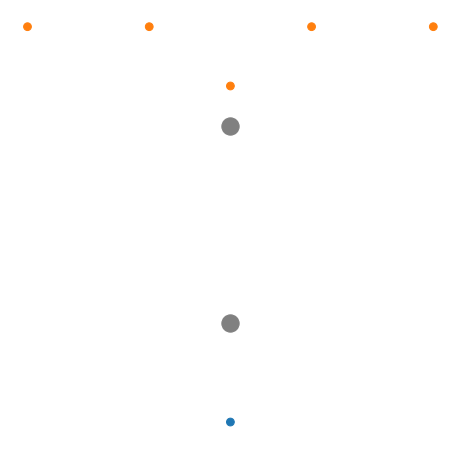

In [83]:
# Simple test with minimize distance strategy
houses_pos = [[0.5,0], [0.3, 1],[0.7, 1],[1,1], [0,1], [0.5, 0.85]]
clinics_pos = [[0.5, 0.25], [0.5, 0.75]]
sim = ClinicsSim(houses_pos,
                 clinics_pos,
                 p_d=0.1,
                 p_r=0.05,
                 alpha=30,
                 gamma=0.1,
                 max_distance=0.75,
                 graph=False,
                 closest=True,
                 clinic_capacity=30,
                 rare_disease_rate=0.5)
sim.initialize()
sim.draw_nodes('reference')

# Three top nodes are assigned to the top clinic and bottom node is assigned to the bottom clinic

C:\Users\rober\Anaconda3\lib\site-packages\ipykernel_launcher.py:423: RuntimeWarning: invalid value encountered in double_scalars


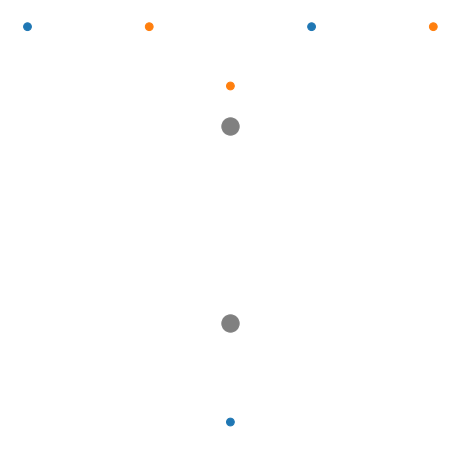

In [84]:
# Now, let's use the minimize standard deviation strategy
sim = ClinicsSim(houses_pos,
                 clinics_pos,
                 p_d=0.1,
                 p_r=0.05,
                 alpha=30,
                 gamma=0.1,
                 max_distance=5,
                 graph=False,
                 closest=False,
                 clinic_capacity=30,
                 rare_disease_rate=0.5)

sim.initialize()
#sim.draw()
ref_clinics = sim.MCMC_assign_clinics(iterations=1000,
                                      n_closest=5,
                                      min_std=True)
sim.create_edges(ref_clinics)
sim.draw_nodes('reference')

# Two of the top nodes switched to be part of the bottom clinic. 

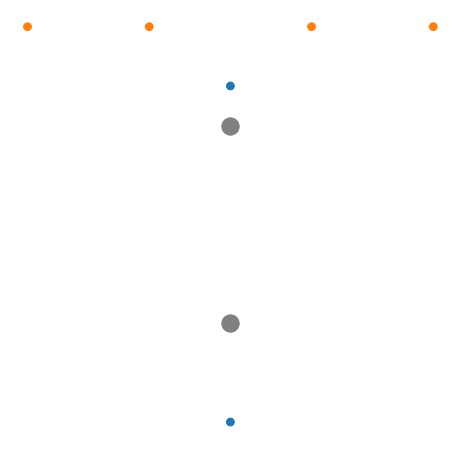

In [85]:
# Finally, let's use the mixed strategy
sim = ClinicsSim(houses_pos,
                 clinics_pos,
                 p_d=0.1,
                 p_r=0.05,
                 alpha=30,
                 gamma=0.1,
                 max_distance=.75,
                 graph=False,
                 closest=False,
                 clinic_capacity=30,
                 rare_disease_rate=0.5)

sim.initialize()
#sim.draw()
ref_clinics = sim.MCMC_assign_clinics(iterations=100,
                                      n_closest=5,
                                      min_std=False)
sim.create_edges(ref_clinics)
sim.draw_nodes('reference')

# Now, only the closest node to the bottom changes because the others are 
# further than the maximum distance specified.

### Simulation of Sayama Town

In [86]:
# Generates random positions for houses and clinics
clinics = 5
houses = 1000
houses_pos = []
clinics_pos = []
for x in range(0,int(houses**0.5)):
    for y in range(0,int(houses**0.5)):
        if random.random() < 0.5:
            houses_pos.append((random.random()*houses**0.5, random.random()*houses**0.5))
            
for i in range(clinics):
    clinics_pos.append((random.random()*houses**0.5, random.random()*houses**0.5))
    


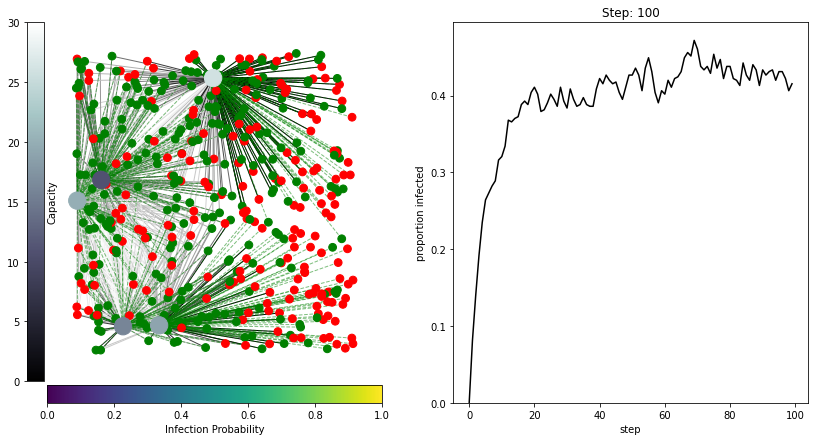

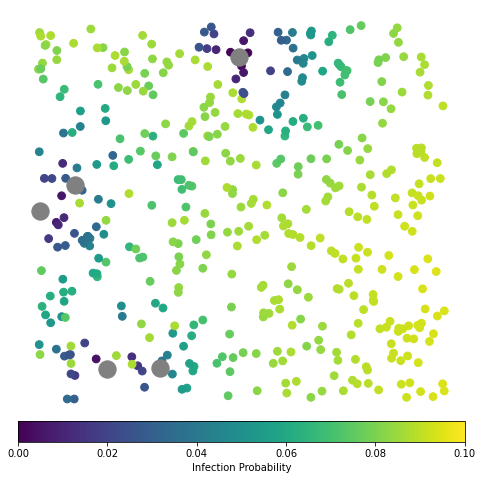

In [88]:
sim = ClinicsSim(houses_pos,
                 clinics_pos,
                 p_d=0.1,
                 p_r=0.05,
                 alpha=30,
                 gamma=0.1,
                 max_distance=15,
                 graph=True,
                 closest=False,
                 clinic_capacity=30,
                 rare_disease_rate=0.5)
sim.initialize()
#sim.draw()
ref_clinics = sim.MCMC_assign_clinics(iterations=100000,
                                      n_closest=5,
                                      min_std=False)
sim.create_edges(ref_clinics)

for i in range(100):
    sim.step()
sim.draw()
sim.draw_nodes('p_d')

In [89]:
sim = ClinicsSim(houses_pos,
                 clinics_pos,
                 p_d=0.1,
                 p_r=0.2,
                 alpha=10,
                 gamma=0.1,
                 max_distance=10,
                 clinic_capacity=20,
                 graph=True)
make_animation(sim, total_frames=20, steps_per_frame=10, interval=250)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.35s/it]

<Figure size 1008x504 with 0 Axes>

In [13]:
def experiment(houses_pos, clinics_pos, trials=10, steps=10, iterations_mcmc = 0, min_std = False, n_closest = 3):
    """
    Runs a clinic simulation multiple times and keeps track of the disease prevalence
    """
    rare_disease_rate = np.linspace(0, 1, 10)
    avg_prevalence = []
    sim = ClinicsSim(houses_pos,
                                   clinics_pos,
                                   p_d=0.1,
                                   p_r=0.05,
                                   alpha=30,
                                   gamma=0.1,
                                   max_distance=15,
                                   graph=False,
                                   closest=False,
                                   clinic_capacity=20,
                                   rare_disease_rate=0)
    sim.initialize()
    nodes = sim.MCMC_assign_clinics(iterations = iterations_mcmc, min_std = min_std, n_closest = n_closest)
    for rate in rare_disease_rate:
        prevalence = []
        for trial in range(trials):
            # Initialize the simulation
            sim = ClinicsSim(houses_pos,
                                   clinics_pos,
                                   p_d=0.1,
                                   p_r=0.05,
                                   alpha=30,
                                   gamma=0.5,
                                   max_distance=15,
                                   graph=False,
                                   closest=False,
                                   clinic_capacity=20,
                                   rare_disease_rate=rate)
            sim.initialize()
            sim.create_edges(nodes)
            # Run until reaching an equilibrium state
            for step in range(steps):
                sim.step()
            # Record the final average traffic flow
            prevalence.append(np.mean(sim.disease_prevalence[:-10]))
        avg_prevalence.append(prevalence)
    avg_prevalence = np.array(avg_prevalence)
    return avg_prevalence

In [14]:
average_p_closest = experiment(houses_pos, clinics_pos, trials = 20, steps = 100)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.65s/it]


In [15]:
average_p_mixed = experiment(houses_pos, clinics_pos, trials = 20, steps = 100, iterations_mcmc=10000)

In [18]:
average_p_min_std = experiment(houses_pos, clinics_pos, trials = 20, steps = 100, iterations_mcmc=10000, min_std = True, n_closest=len(clinics_pos))

C:\Users\rober\Anaconda3\lib\site-packages\ipykernel_launcher.py:408: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\rober\Anaconda3\lib\site-packages\ipykernel_launcher.py:408: RuntimeWarning: invalid value encountered in double_scalars


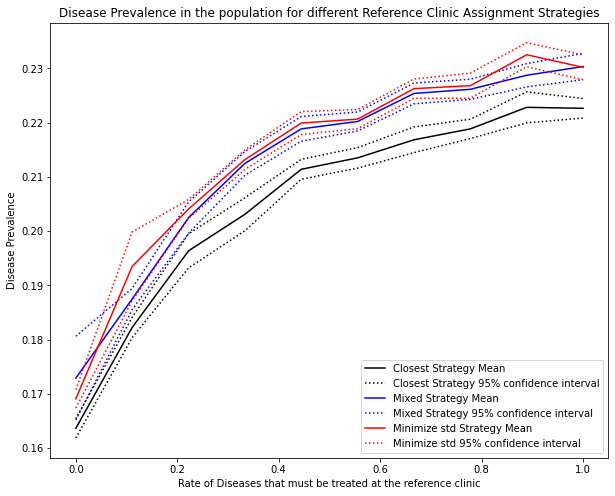

In [19]:
# Plot the experiment results. 
# The graph looks different from the paper because the positions of the house and clinic are random 
# and the parameters are different

import scipy.stats as sts
rare_disease_rate = np.linspace(0, 1, 10)
plt.figure(figsize=(10, 8))
plt.title('Disease Prevalence in the population for different Reference Clinic Assignment Strategies')
plt.xlabel('Rate of Diseases that must be treated at the reference clinic')
plt.ylabel('Disease Prevalence')

rate_mean = np.mean(average_p_closest, axis = 1)
std_err = sts.sem(average_p_closest, axis = 1)
mixed_rate_mean = np.mean(average_p_mixed, axis=1)
mixed_std_err = sts.sem(average_p_mixed, axis=1)
min_std_rate_mean = np.mean(average_p_min_std, axis=1)
min_std_std_err = sts.sem(average_p_min_std, axis=1)


plt.plot(rare_disease_rate, rate_mean, 'k-', label='Closest Strategy Mean')
plt.plot(rare_disease_rate, rate_mean - 1.96 * std_err, 'k:',
         label='Closest Strategy 95% confidence interval')
plt.plot(rare_disease_rate, rate_mean + 1.96 * std_err, 'k:')

plt.plot(rare_disease_rate, mixed_rate_mean, 'b-', label='Mixed Strategy Mean')
plt.plot(rare_disease_rate, mixed_rate_mean - 1.96 * mixed_std_err, 'b:',
         label='Mixed Strategy 95% confidence interval')
plt.plot(rare_disease_rate, mixed_rate_mean + 1.96 * mixed_std_err, 'b:')

plt.plot(rare_disease_rate, min_std_rate_mean, 'r-', label='Minimize std Strategy Mean')
plt.plot(rare_disease_rate, min_std_rate_mean - 1.96 * min_std_std_err, 'r:',
         label='Minimize std 95% confidence interval')
plt.plot(rare_disease_rate, min_std_rate_mean + 1.96 * min_std_std_err, 'r:')

plt.legend()
plt.show()